In [ ]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm as tqdm
import scipy
from scipy import signal


import dask
from dask import dataframe
from dask import delayed
from dask.distributed import Client, LocalCluster, TimeoutError

from matplotlib2tikz import save as tikz_save

from utils import cross_correlation


%matplotlib inline

pd.options.display.max_rows = 15

%load_ext autoreload
%autoreload 2

In [2]:
DATAPATH = 'data'

In [ ]:
from dask.distributed import Client, TimeoutError

try:
    client = Client('tcp://localhost:8786', timeout='2s')
except (TimeoutError, OSError):
    client = Client(LocalCluster())
    
client

In [4]:
def load_data(filepath):
    df = pd.read_excel(filepath, 
                       dtype={'Étudiant - PPG': np.float32, 'Directeur - Pulse': np.float32, 'Étudiant - Rate': np.float32,
                                   'Directeur - Rate': np.float32, 'Étudiant - EDA': np.float32, 'Directeur - EDA': np.float32},
                       na_values= '-',)
    df['dyade'] = int(re.search('dyade_(\d+)', filepath, flags=re.I).groups()[0])
    return df

In [5]:
filepaths = [os.path.join(DATAPATH, _) for _ in os.listdir(DATAPATH) if 'xlsx' in _]

dfs = client.gather(client.map(load_data, filepaths))

In [6]:
df_all = pd.concat(dfs, sort=False)
df_all = df_all.drop(columns=['Sync', 'Sync2', 'NOT(LESS(CH16', 'Date_Time_Absolute_dmy_hmsf', 
                              'Date_dmy', 'Time_Absolute_hms', 'Time_Absolute_f', 'Time_Relative_hmsf',
                              'Time_Relative_hms', 'Time_Relative_f'
                             ]).copy()
del dfs
df_all = df_all.rename(columns={'Time_Relative_sf':'time'})
df_all.Behavior = np.where(df_all.Behavior.isna(), df_all['Behavior.1'], df_all.Behavior)

# Analyse Éduqués Stressés

# Rythme cardiaque

On trouve les sections avec des données de rythme cardiaque invalides

In [172]:
df_all['Directeur - Rate Valid']  = (30 < df_all['Directeur - Rate']) & (df_all['Directeur - Rate'] < 150)
df_all['Étudiant - Rate Valid']  = (30 < df_all['Étudiant - Rate']) & (df_all['Étudiant - Rate'] < 150)

df_all['Directeur - Rate Valid']  = df_all['Directeur - Rate Valid'] & (df_all['Directeur - Rate'] < (df_all.loc[df_all['Directeur - Rate Valid'], 'Directeur - Rate'].mean() + 3*df_all.loc[df_all['Directeur - Rate Valid'], 'Directeur - Rate'].std()))
df_all['Étudiant - Rate Valid']  =  df_all['Étudiant - Rate Valid'] & (df_all['Étudiant - Rate'] < (df_all.loc[df_all['Étudiant - Rate Valid'], 'Étudiant - Rate'].mean() + 3*df_all.loc[df_all['Étudiant - Rate Valid'], 'Étudiant - Rate'].std()))

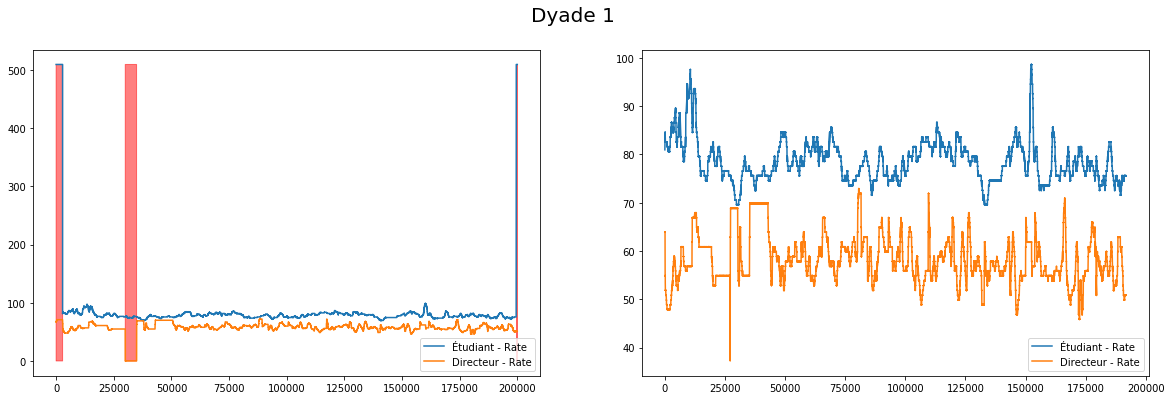

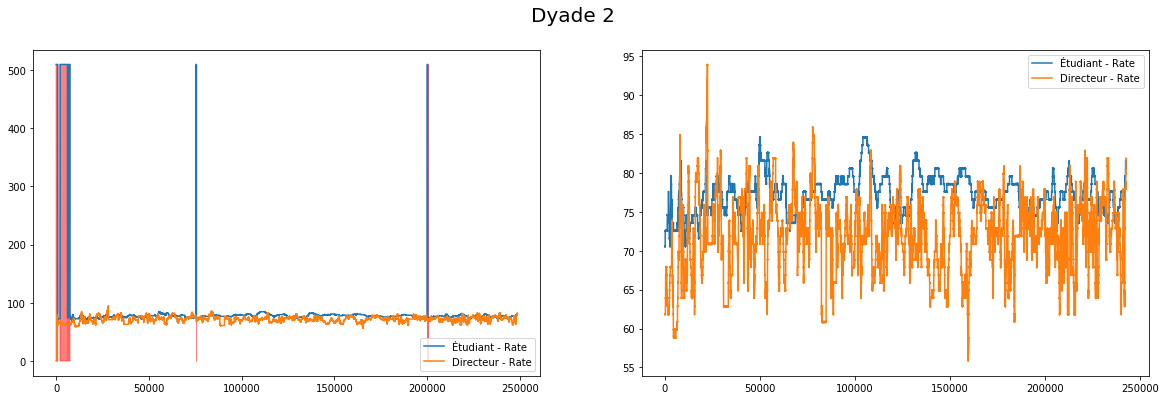

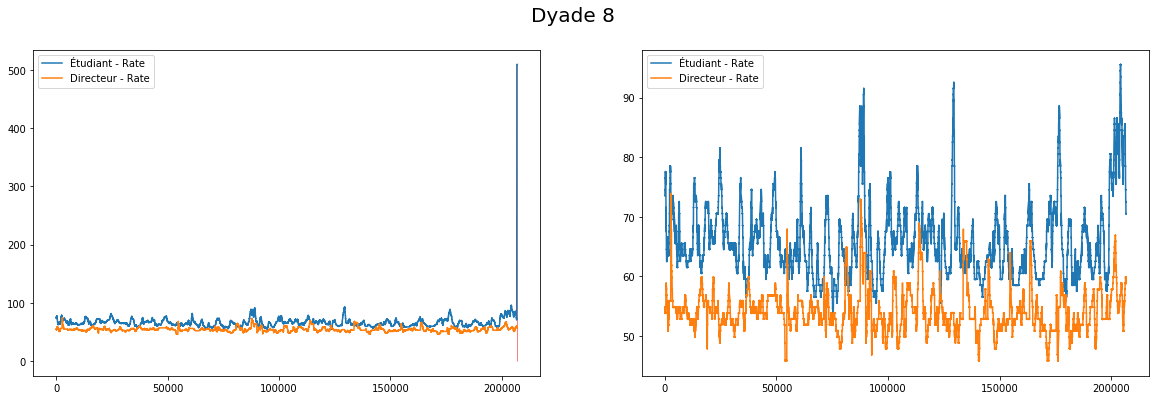

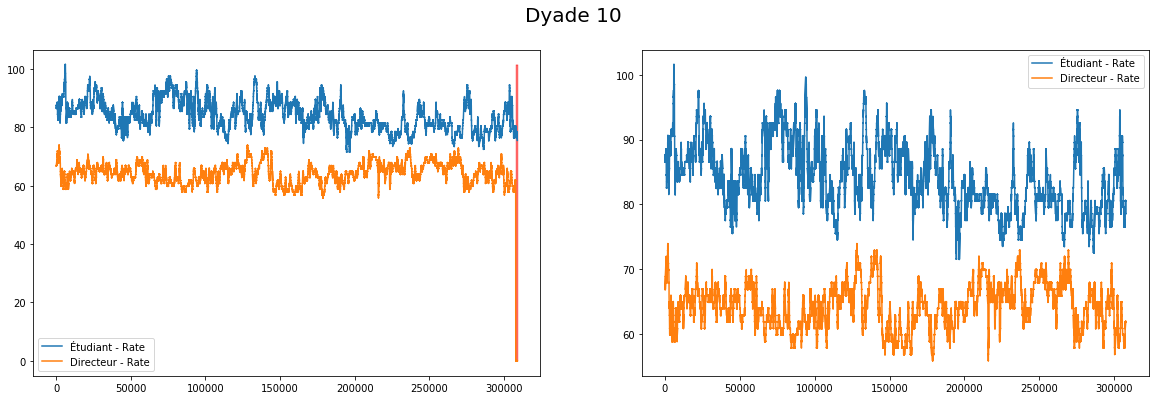

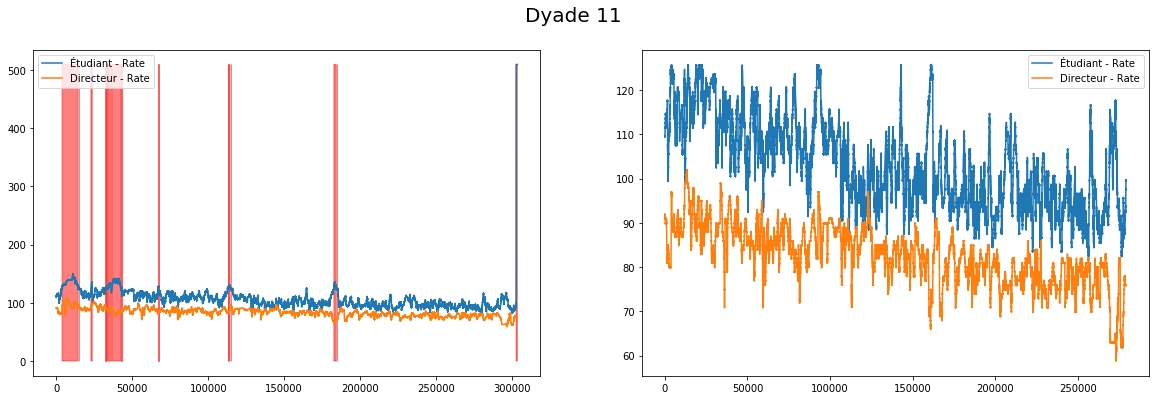

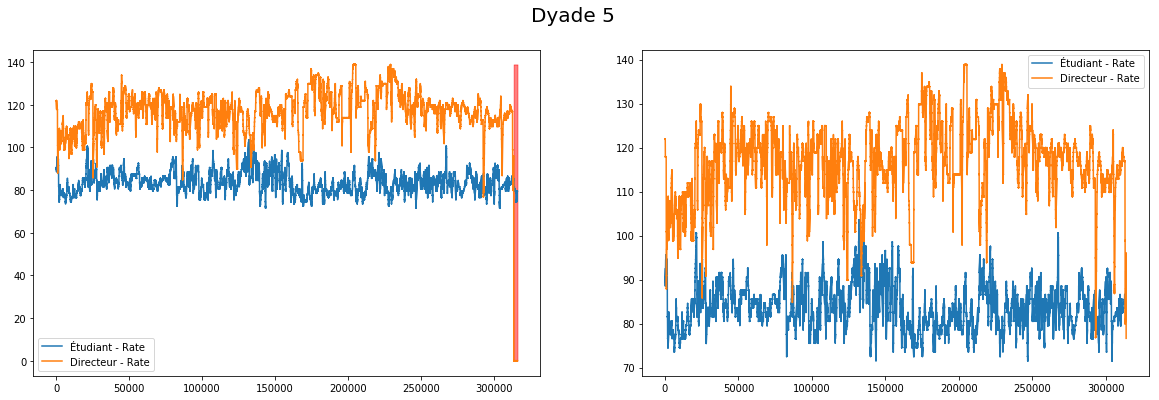

In [245]:
for dyade in df_all.dyade.unique()[:]:
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Dyade {}'.format(dyade), size=20)
    axs = fig.subplots(1, 2)
    df_dyade = df_all.loc[df_all.dyade==dyade, :].copy()    
    
    df_dyade.loc[:, ['Étudiant - Rate', 'Directeur - Rate']].plot(ax=axs[0])
    valid_mask = df_dyade['Étudiant - Rate Valid'] & df_dyade['Directeur - Rate Valid']
    max_value = np.nanmax(df_dyade.loc[:, ['Étudiant - Rate', 'Directeur - Rate']].values)
    axs[0].fill_between(df_dyade.index, np.bitwise_not(valid_mask) * max_value, where=np.bitwise_not(valid_mask), color='r', alpha=0.5)
    
    try:
        df_dyade.loc[:, ['Étudiant - Rate', 'Directeur - Rate']].loc[valid_mask, :].plot(use_index=False, ax=axs[1])
    except TypeError:
        pass
    
    plt.show()

## Quel est le pourcentage des données où les rythmes cardiac sont valides pour les deux participants

In [155]:
print("{:0.1%}".format(len(df_all[df_all['Directeur - Rate Valid'] & df_all['Étudiant - Rate Valid']]) / len(df_all)))

98.8%


## Est-ce que les directeurs et les étudiants ont un rythme cardiaque moyen statistiquement différent?

In [156]:
df_average = df_all[df_all['Directeur - Rate Valid'] & df_all['Étudiant - Rate Valid']].groupby('dyade').agg(['mean', 'std'])

In [157]:
scipy.stats.ttest_ind(df_average['Étudiant - Rate']['mean'], df_average['Directeur - Rate']['mean'])

Ttest_indResult(statistic=0.7209746832900255, pvalue=0.4874377869101917)

Non

## Est-ce que les directeurs et les étudiants ont une variabilité cardiaque moyenne statistiquement différente?

In [158]:
scipy.stats.ttest_ind(df_average['Étudiant - Rate']['std'], df_average['Directeur - Rate']['std'])

Ttest_indResult(statistic=0.30008235299690905, pvalue=0.770259601540728)

Non

## Est-ce qu'il y a une corrélation entre les ryhtmes cardiaques

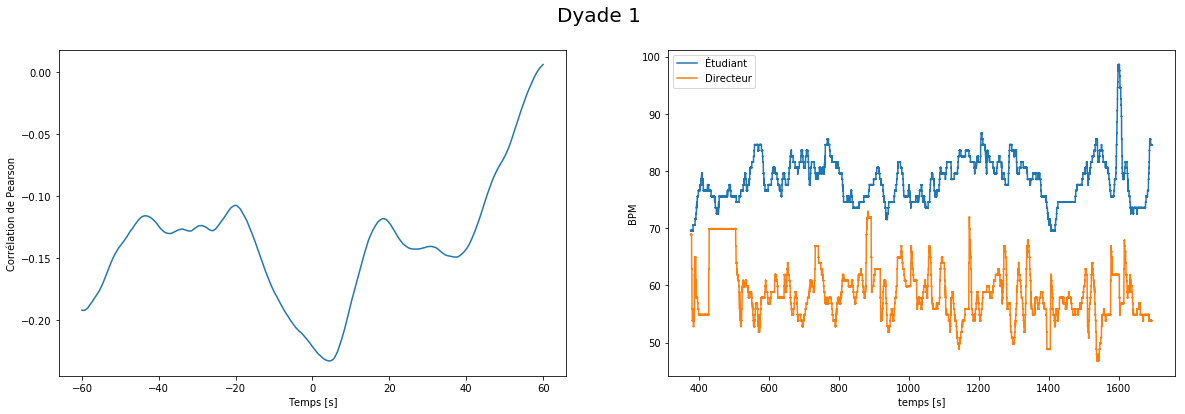

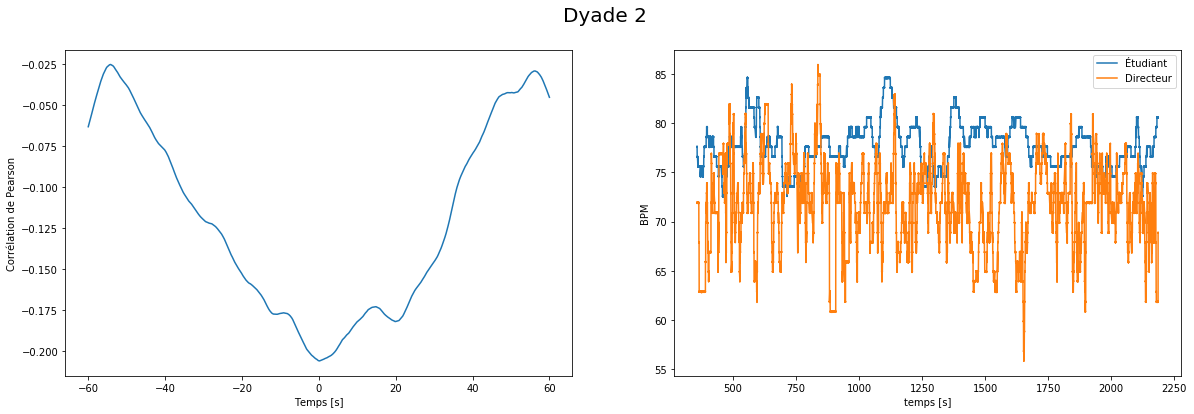

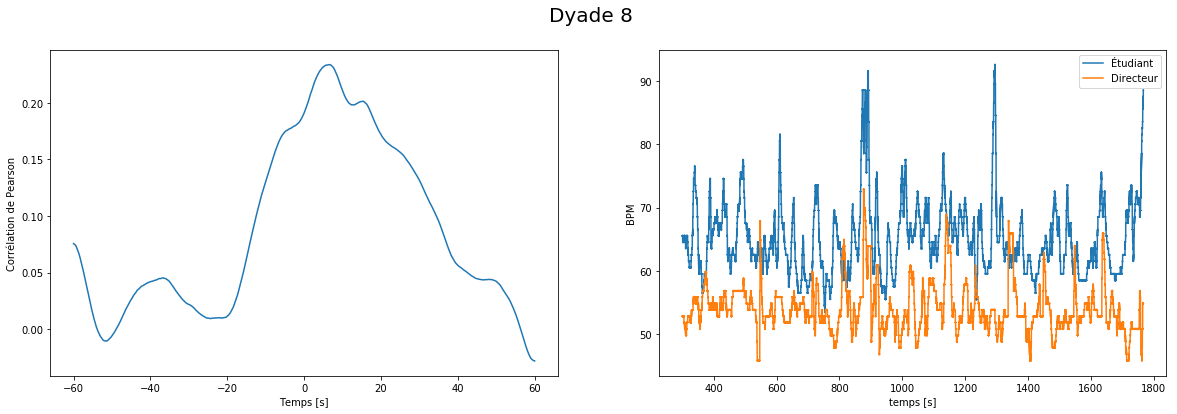

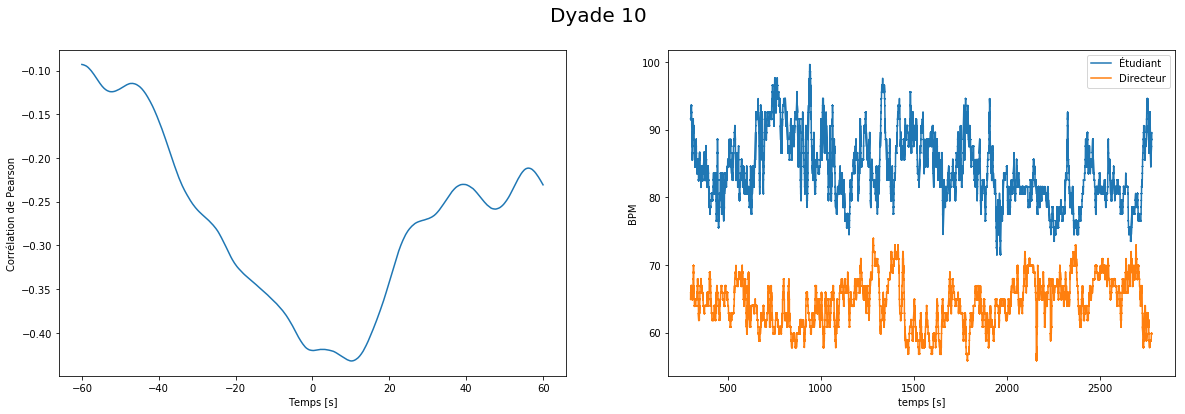

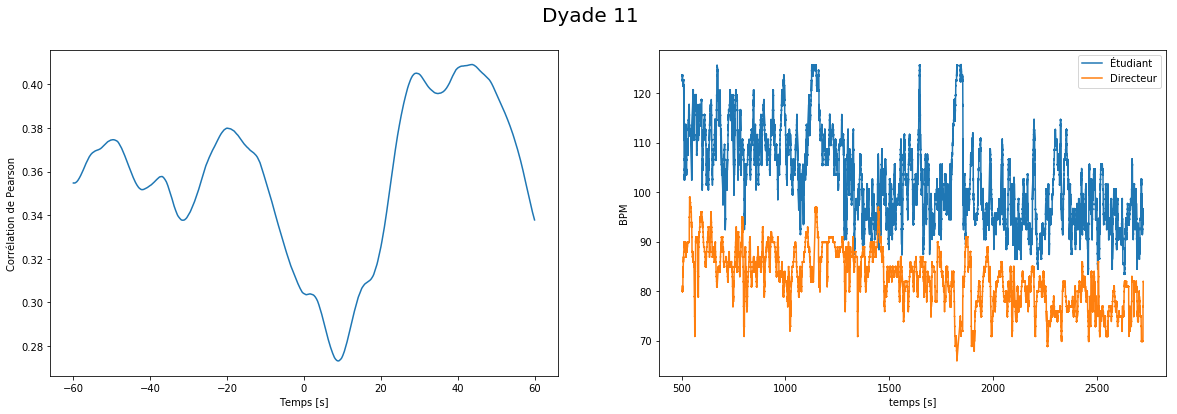

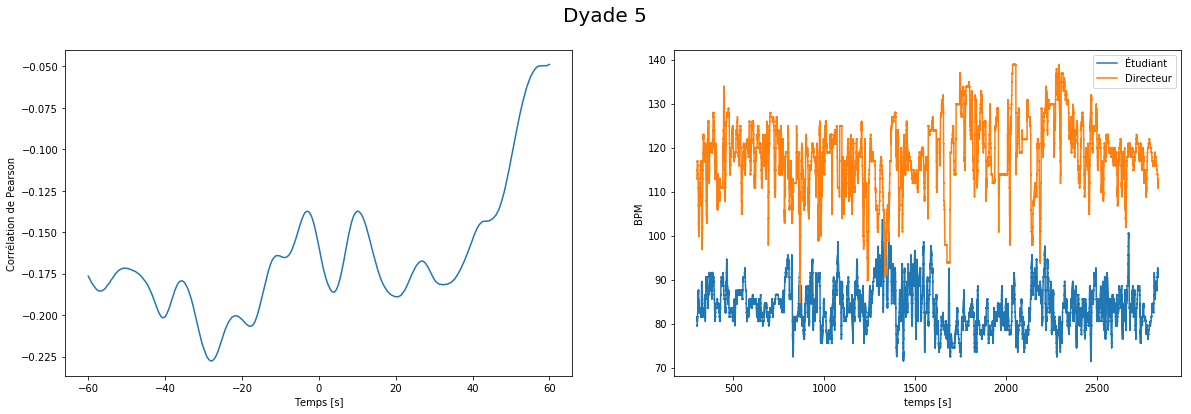

In [246]:
df_valid_rate = df_all.loc[df_all['Directeur - Rate Valid'] & df_all['Étudiant - Rate Valid'], :]
for dyade in df_valid_rate.dyade.unique()[:]:
    df_dyade = df_valid_rate[df_valid_rate.dyade==dyade].iloc[5*6000:5*-6000] # on enlève les 5 première et dernière minutes
    corr = cross_correlation(df_dyade['Directeur - Rate'].values, df_dyade['Étudiant - Rate'].iloc[6000:-6000]) # on fait la cross-corélation à ±60sec
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Dyade {}'.format(dyade), size=20)
    axs = fig.subplots(1, 2)
    axs[0].plot(np.arange(-len(corr)//2,len(corr)//2)/100,  corr)
    axs[0].set_xlabel('Temps [s]')
    axs[0].set_ylabel('Corrélation de Pearson')
    
    axs[1].plot(df_dyade['Étudiant - Rate'].index/100, df_dyade['Étudiant - Rate'].values)
    axs[1].plot(df_dyade['Directeur - Rate'].index/100, df_dyade['Directeur - Rate'].values)
    axs[1].legend(['Étudiant', 'Directeur'])
    axs[1].set_ylabel('BPM')
    axs[1].set_xlabel('temps [s]')
    plt.show()

Pour certain, Négative et Positive, d'autre non  
Il faudrait comparer avec les corélations entre participant qui ne sont pas dans la même dyade

# Eda

In [213]:
def extract_phasic(eda):
    eda = eda[:]
    eda[np.isnan(eda)] = 0
    fs = 100
    nyquist = fs/2
    lcof = 0.05
    hcof = 2
    
    wn = np.array([lcof, hcof])/nyquist
    
    b, a = scipy.signal.butter(4, wn, btype='bandpass')
    
    return scipy.signal.filtfilt(b, a, eda)

On nettoie les données en enlevant les mauvaises sections

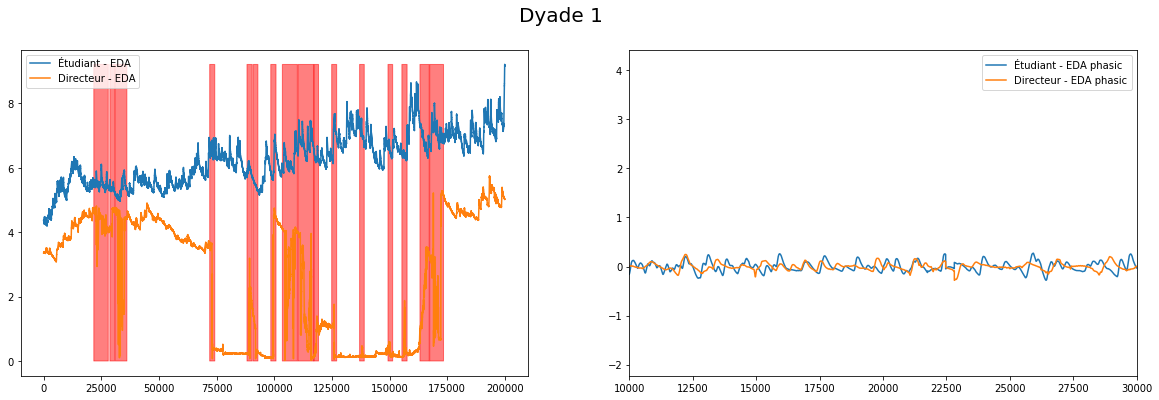

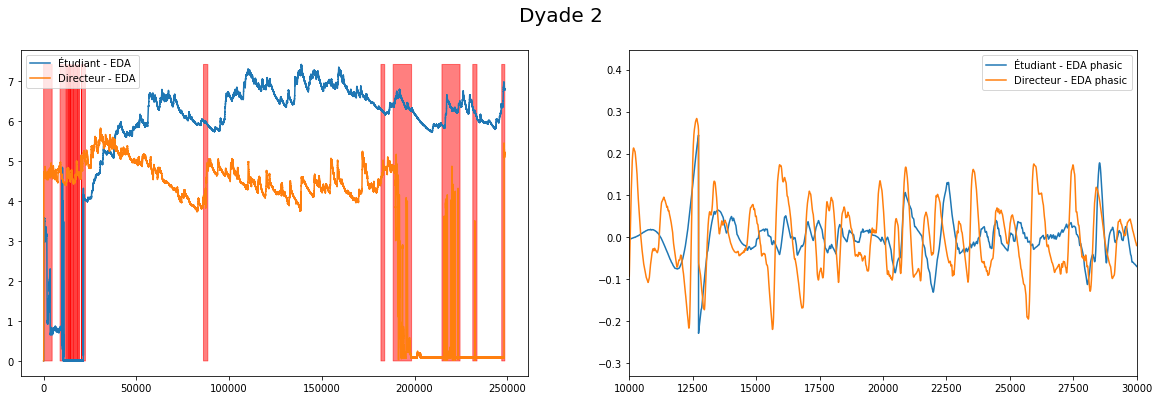

Le signal phasic ne bouge pas assez


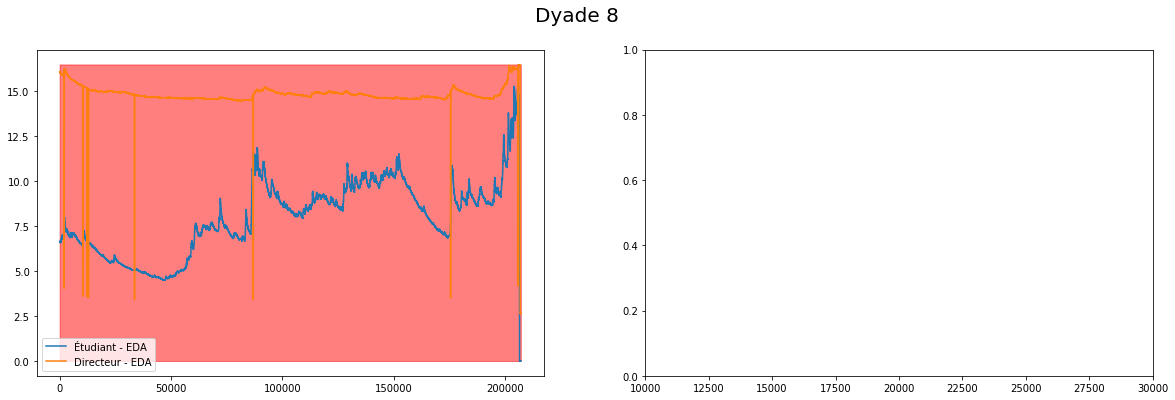

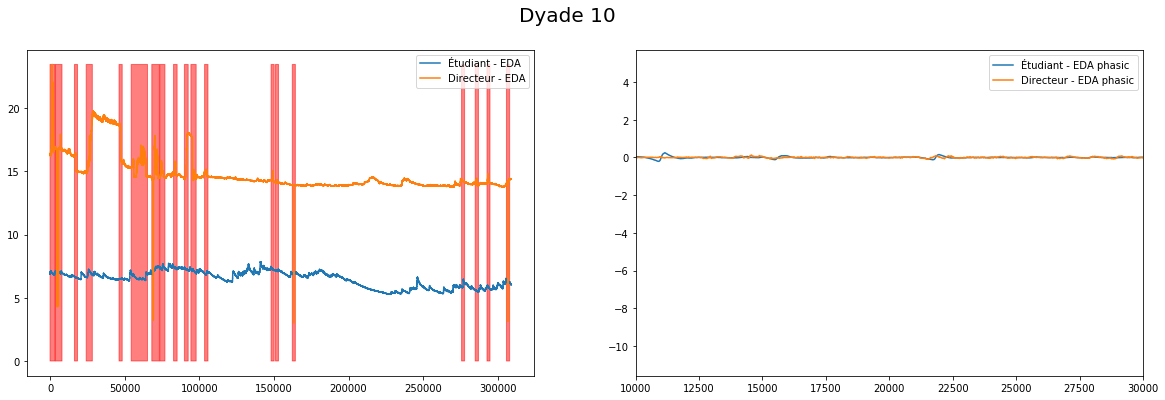

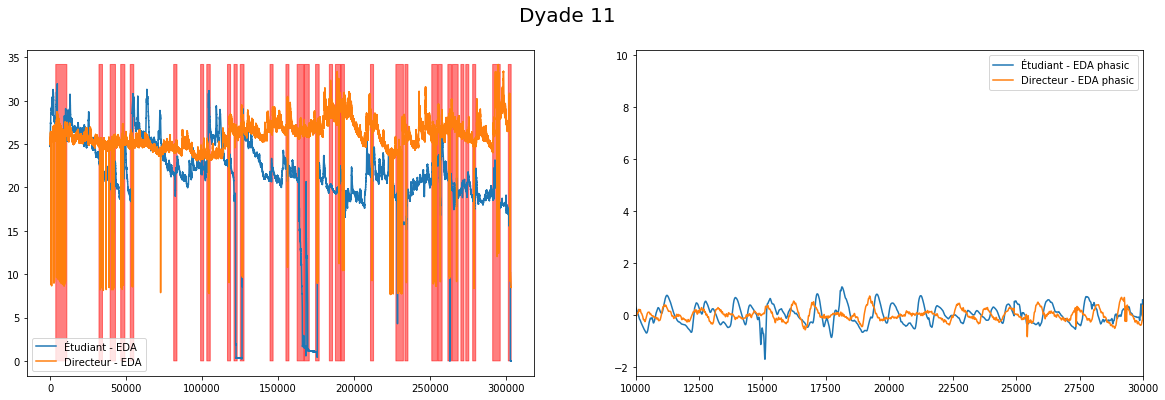

Le signal phasic ne bouge pas assez


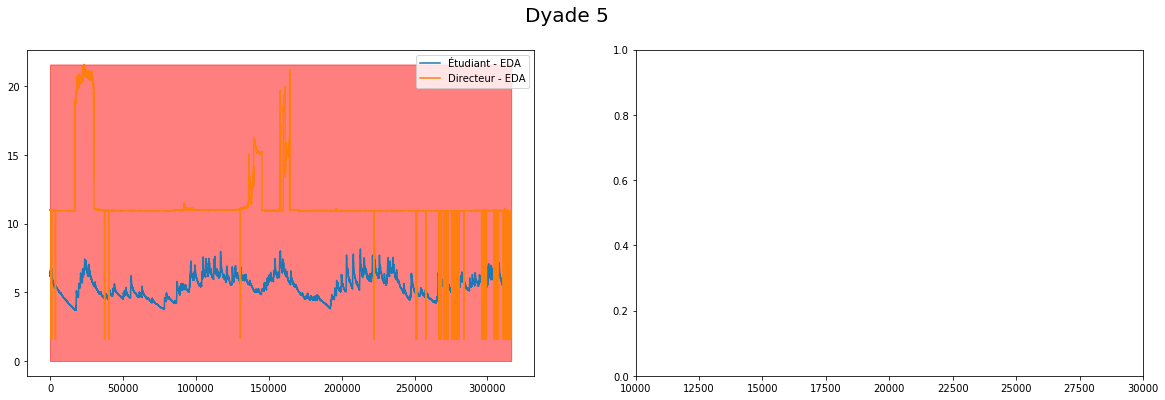

In [247]:
def compute_valid_eda_mask(eda):
    mask = eda[:]
    mask[np.isnan(mask)] = -1
    mask = mask > 0
    
    phasic = extract_phasic(eda)
    
    # on enleve les sections où il y a un grand changement
    change = np.abs(np.ediff1d(phasic, to_begin=0))
    limit = np.sort(change)[:int(0.75*len(change))].std()*50
    
    mask = mask & ((np.convolve(change>limit, np.ones(2000), mode='same')) <= 1)    
    
    phasic = phasic[mask]
    
    
    # on enleve les signals qui ne bougent pas assez

    if (np.sum(np.abs(phasic))/len(phasic)) < 0.01:
        print('Le signal phasic ne bouge pas assez')
        mask = (mask * 0).astype(bool)
    
    return mask

df_all['Étudiant - EDA valid'] = True
df_all['Directeur - EDA valid'] = True

df_all['Étudiant - EDA phasic'] = extract_phasic(df_all['Étudiant - EDA'])
df_all['Directeur - EDA phasic'] = extract_phasic(df_all['Directeur - EDA'])


for dyade in df_all.dyade.unique()[:]:
    df_dyade = df_all.loc[df_all.dyade==dyade, :].copy()
    df_dyade.loc[:, 'Étudiant - EDA valid'] = compute_valid_eda_mask(df_dyade['Étudiant - EDA'])
    df_dyade.loc[:, 'Directeur - EDA valid'] = compute_valid_eda_mask(df_dyade['Directeur - EDA'])
    
    df_all.loc[df_all.dyade==dyade, 'Étudiant - EDA valid'] = df_dyade.loc[:, 'Étudiant - EDA valid']
    df_all.loc[df_all.dyade==dyade, 'Directeur - EDA valid'] = df_dyade.loc[:, 'Directeur - EDA valid']
    
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Dyade {}'.format(dyade), size=20)
    axs = fig.subplots(1, 2)
    
    df_dyade.loc[:, ['Étudiant - EDA', 'Directeur - EDA']].plot(ax=axs[0])
    valid_mask = df_dyade['Étudiant - EDA valid'] & df_dyade['Directeur - EDA valid']
    max_value = np.nanmax(df_dyade.loc[:, ['Étudiant - EDA', 'Directeur - EDA']].values)
    axs[0].fill_between(df_dyade.index, np.bitwise_not(valid_mask) * max_value, where=np.bitwise_not(valid_mask), color='r', alpha=0.5)
    
    try:
        df_dyade.loc[:, ['Étudiant - EDA phasic', 'Directeur - EDA phasic']].loc[valid_mask, :].plot(use_index=False, ax=axs[1])
    except TypeError:
        pass
    
    axs[1].set_xlim(10000, 30000)
    plt.show()

## Quel est le pourcentage des données où les EDA sont valides pour les deux participants

In [241]:
print("{:0.1%}".format(len(df_all[df_all['Directeur - EDA valid'] & df_all['Étudiant - EDA valid']]) / len(df_all)))

51.7%


## Est-ce qu'il y a une corrélation entre la composante phasique de l'EDA?

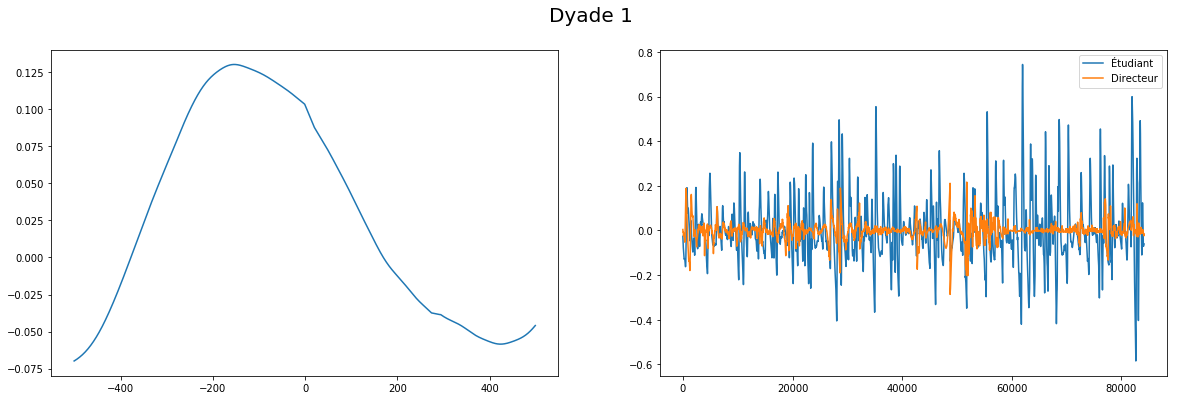

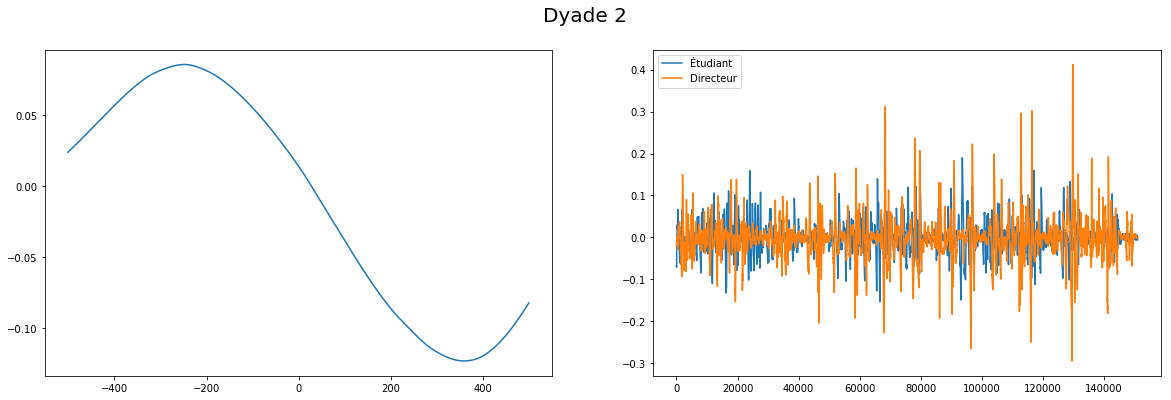

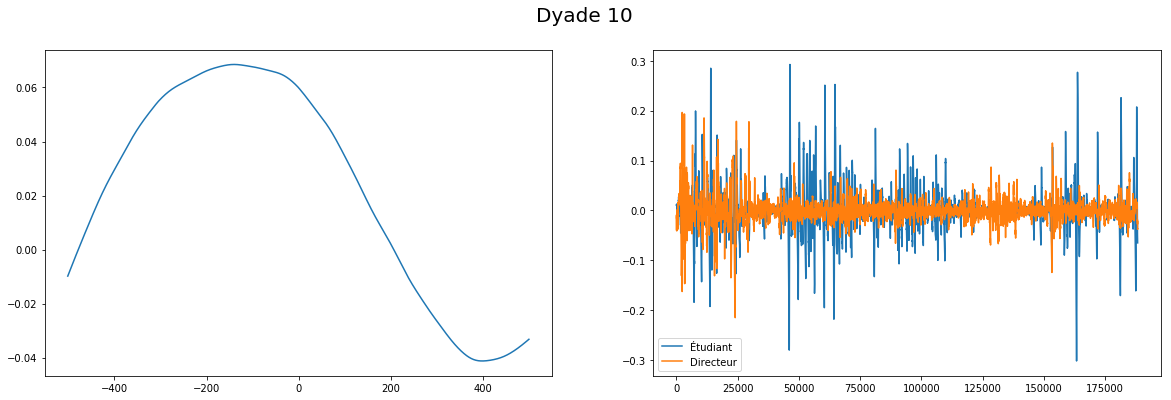

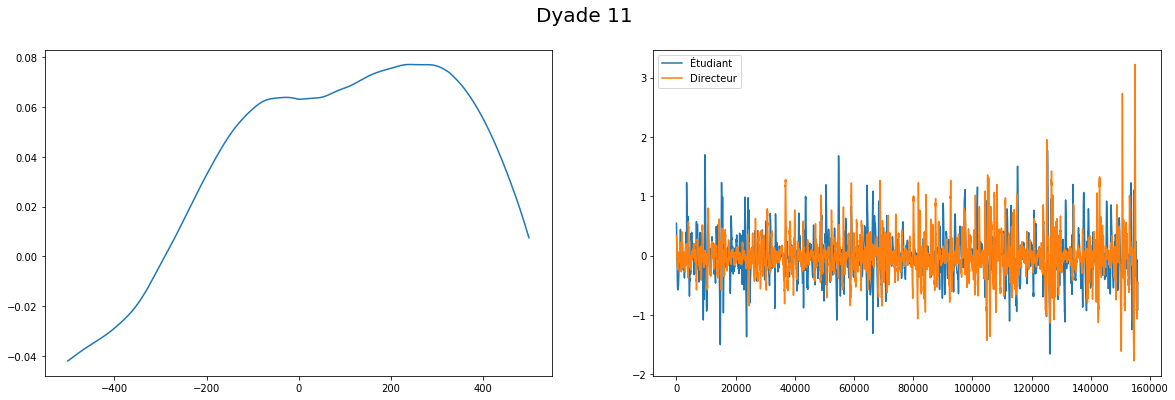

In [248]:
df_valid_eda = df_all[df_all['Directeur - EDA valid'] & df_all['Étudiant - EDA valid']]
for dyade in df_valid_eda.dyade.unique()[:]:
    df_dyade = df_valid_eda[df_valid_eda.dyade==dyade].iloc[5*6000:5*-6000] # on enlève les 5 première et dernière minutes
    corr = cross_correlation(df_dyade['Directeur - EDA phasic'].values, df_dyade['Étudiant - EDA phasic'].iloc[500:-500]) # on fait la cross-corélation à ±5sec
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Dyade {}'.format(dyade), size=20)
    axs = fig.subplots(1, 2)
    axs[0].plot(np.arange(-len(corr)//2,len(corr)//2),  corr)
    axs[1].plot(df_dyade['Étudiant - EDA phasic'].values)
    axs[1].plot(df_dyade['Directeur - EDA phasic'].values)
    axs[1].legend(['Étudiant', 'Directeur'])
    plt.show()

Pas vraiment

In [258]:
!jupyter  nbconvert --to=html --template hideinput --output="EduquesStresses.html"  "1-1 data exploration.ipynb" 

[NbConvertApp] Converting notebook 1-1 data exploration.ipynb to html
[NbConvertApp] Writing 2240885 bytes to EduquesStresses.html
